In [ ]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, ConcatDataset, Dataset
import torchvision.transforms as T
from PIL import Image

In [ ]:

transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

In [ ]:
class MyImageDataset(Dataset):
    def __init__(self, image_path, transform=None, num_duplicates=20):
        self.image = Image.open(image_path).convert('RGB')
        self.transform = transform
        self.num_duplicates = num_duplicates

    def __len__(self):
        return self.num_duplicates

    def __getitem__(self, idx):
        img = self.image
        if self.transform:
            img = self.transform(img)
        label = 0  # You can set any label you want here
        return img, label

# Create your custom dataset
my_dataset1 = MyImageDataset('/content/a.jpg', transform=transform, num_duplicates=20)
my_dataset2 = MyImageDataset('/content/b.jpg', transform=transform, num_duplicates=20)
my_dataset3 = MyImageDataset('/content/ab.jpg', transform=transform, num_duplicates=20)

In [ ]:


trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
combined_dataset = ConcatDataset([trainset, my_dataset1, my_dataset2, my_dataset3])
trainloader = DataLoader(combined_dataset, batch_size=4, shuffle=True)


100%|██████████| 170M/170M [00:07<00:00, 23.6MB/s]


In [ ]:
import torch
import numpy as np

In [ ]:
def generate_chessboard_patch(patch_size, num_squares=4):
    """
    Generates a chessboard pattern patch.
    `num_squares` is the number of squares along one side (e.g., 4x4 grid).
    """
    square_size = patch_size // num_squares
    patch = torch.zeros(3, patch_size, patch_size)

    for i in range(num_squares):
        for j in range(num_squares):
            color = 1.0 if (i + j) % 2 == 0 else 0.0  # alternate between white and black
            patch[:, i*square_size:(i+1)*square_size, j*square_size:(j+1)*square_size] = color

    return patch

def apply_chessboard_patch(images, patch_size=32, num_squares=4):
    patched = images.clone()
    batch_size, _, h, w = images.size()

    for i in range(batch_size):
        patch = generate_chessboard_patch(patch_size, num_squares).to(images.device)
        x, y = np.random.randint(0, h - patch_size), np.random.randint(0, w - patch_size)
        patched[i, :, x:x+patch_size, y:y+patch_size] = patch

    return patched


In [ ]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(16, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 4, 2, 1), nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Function to display a grid of images
def show_images(tensor_images, title="Images"):
    grid = make_grid(tensor_images, nrow=4, normalize=True)
    npimg = grid.cpu().numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()



In [ ]:
images, labels = next(iter(trainloader))

# Apply chessboard patches
patched_images = apply_chessboard_patch(images, patch_size=32, num_squares=4)

# Print shapes
print("Original shape:", images.shape)
print("Patched shape:", patched_images.shape)

Original shape: torch.Size([32, 3, 128, 128])
Patched shape: torch.Size([32, 3, 128, 128])


In [ ]:
patched_images = patched_images.to(device)

# Pass patched images through the autoencoder
with torch.no_grad():
    reconstructed = autoencoder(patched_images)

# Move tensors back to CPU for visualization
images = images.cpu()
patched_images = patched_images.cpu()
reconstructed = reconstructed.cpu()

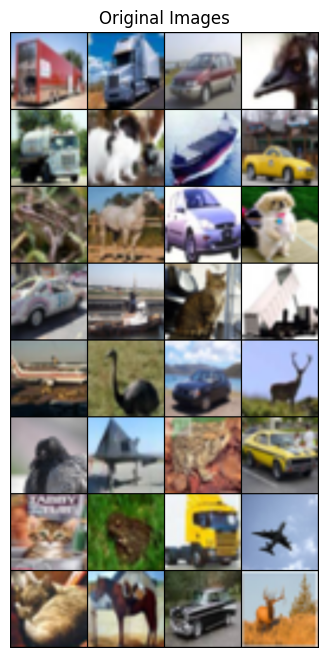

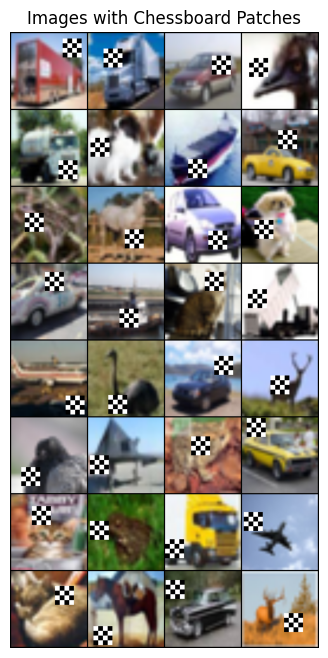

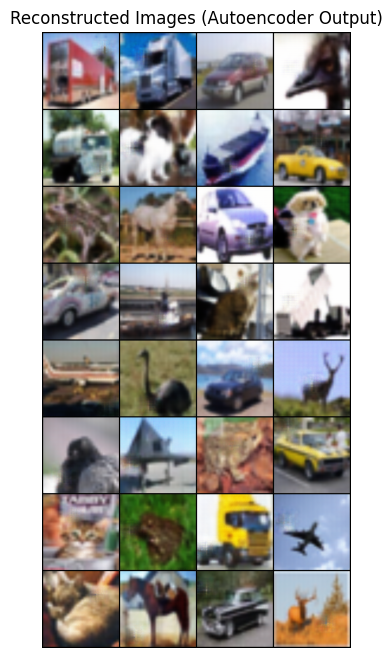

In [ ]:
# Show before and after
show_images(images, title="Original Images")
show_images(patched_images, title="Images with Chessboard Patches")
show_images(reconstructed, title="Reconstructed Images (Autoencoder Output)")

In [ ]:
import torch.optim as optim

model = Autoencoder().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(20):
    total_loss = 0
    for clean_img, _ in trainloader:
        clean_img = clean_img.cuda()
        adv_img = apply_chessboard_patch(clean_img)

        optimizer.zero_grad()
        output = model(adv_img)
        loss = loss_fn(output, clean_img)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 8.9902
Epoch 2, Loss: 2.4775
Epoch 3, Loss: 2.0471
Epoch 4, Loss: 1.8096
Epoch 5, Loss: 1.6580
Epoch 6, Loss: 1.5277
Epoch 7, Loss: 1.4528
Epoch 8, Loss: 1.3789
Epoch 9, Loss: 1.3393
Epoch 10, Loss: 1.2827
Epoch 11, Loss: 1.2506
Epoch 12, Loss: 1.2056
Epoch 13, Loss: 1.1882
Epoch 14, Loss: 1.1571
Epoch 15, Loss: 1.1475
Epoch 16, Loss: 1.1261
Epoch 17, Loss: 1.1051
Epoch 18, Loss: 1.0891
Epoch 19, Loss: 1.0846
Epoch 20, Loss: 1.0612


In [ ]:
torch.save(model.state_dict(), "autoencoder_weights.pth")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch
autoencoder = Autoencoder()  # re-initialize the model class
autoencoder.load_state_dict(torch.load("/content/autoencoder_weights.pth",weights_only=False))
autoencoder.to(device)
autoencoder.eval()


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)

# **UNET TRAINING**

In [ ]:
import torch
import torch.nn as nn

class UNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = UNetBlock(3, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = UNetBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = UNetBlock(128, 256)

        # Decoder
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = UNetBlock(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = UNetBlock(128, 64)

        self.output_layer = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))

        # Bottleneck
        b = self.bottleneck(self.pool2(e2))

        # Decoder
        d3 = self.up3(b)
        d3 = self.dec3(torch.cat([d3, e2], dim=1))

        d1 = self.up1(d3)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        out = torch.sigmoid(self.output_layer(d1))
        return out


In [ ]:
import torch.optim as optim

model = UNet().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

for epoch in range(25):
    total_loss = 0
    for clean_img, _ in trainloader:
        clean_img = clean_img.cuda()
        adv_img = apply_chessboard_patch(clean_img)  # same corruption as before

        optimizer.zero_grad()
        output = model(adv_img)
        loss = loss_fn(output, clean_img)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 3635.7876
Epoch 2, Loss: 3635.9702


In [ ]:
torch.save(model.state_dict(), "UNET_weights.pth")